## Bibiliothèque

In [54]:
import numpy as np
import tensorflow as tf;
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from Distiller import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
seed = tf.random.set_seed(10)


## Utils

In [55]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [56]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [57]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits");
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================
Evaluation of Teacher model!
313/313 [==============================] - 12s 35ms/step - loss: 0.5328 - sparse_categorical_accuracy: 0.9054



## Building a preprocessing routine

In [58]:
print(" ============== Adding preprocessing layers ===============")
preprocessing = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(32, 32, seed= seed),
    tf.keras.layers.RandomFlip(mode="horizontal", seed= seed),

])

 ============== Adding preprocessing layers ===============


## Building Lenet5 Student model 

In [59]:
print("============== Building Student Network Lenet5 ! =============")

student = tf.keras.Sequential([
    preprocessing,
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding="valid"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=120, activation='relu'),
    tf.keras.layers.Dense(units=84, activation='relu'),
    tf.keras.layers.Dense(units=10)

]);




============== Building Student Network Lenet5 ! =============


## Building callbacks

In [60]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)

lr_reduce2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)

## Scratch training

In [61]:
student_scratch = tf.keras.Sequential([
    student,
    tf.keras.layers.Activation("softmax"),
    
])

In [62]:

BATCH_SIZE = 32
EPOCHS = 100
lr = 0.1

NAME = f"Lenet5_scratch"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                                 histogram_freq = 1)


student_scratch.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        )

    # Train and evaluate on data.
hist = student_scratch.fit(x_train, y_train, 
      batch_size = BATCH_SIZE,
      epochs=EPOCHS,
      steps_per_epoch = len(x_train)/BATCH_SIZE,
      validation_data =(x_test, y_test),
      workers =40,
      use_multiprocessing= True,
      callbacks = [lr_reduce2, tensorboard],
      )


student_scratch.evaluate(x_test, y_test)

print("")

print("End !")

Epoch 1/100
1562/1562 [==============================] - 18s 11ms/step - loss: 1.8936 - sparse_categorical_accuracy: 0.3114 - val_loss: 1.9218 - val_sparse_categorical_accuracy: 0.3534 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 16s 10ms/step - loss: 1.5326 - sparse_categorical_accuracy: 0.4490 - val_loss: 1.5513 - val_sparse_categorical_accuracy: 0.4477 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 16s 10ms/step - loss: 1.4195 - sparse_categorical_accuracy: 0.4886 - val_loss: 1.4102 - val_sparse_categorical_accuracy: 0.4893 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 16s 10ms/step - loss: 1.3478 - sparse_categorical_accuracy: 0.5185 - val_loss: 1.4139 - val_sparse_categorical_accuracy: 0.5044 - lr: 0.1000
Epoch 5/100
1562/1562 [==============================] - 16s 10ms/step - loss: 1.2932 - sparse_categorical_accuracy: 0.5365 - val_loss: 1.2785 - val_sparse_categorical_accuracy: 0.5450 - lr: 0.1000
Epoch 6/10

Epoch 41/100
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5910 - sparse_categorical_accuracy: 0.7914 - val_loss: 1.2165 - val_sparse_categorical_accuracy: 0.6331 - lr: 1.0000e-03
Epoch 42/100
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5877 - sparse_categorical_accuracy: 0.7948 - val_loss: 1.2185 - val_sparse_categorical_accuracy: 0.6357 - lr: 1.0000e-03
Epoch 43/100
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5839 - sparse_categorical_accuracy: 0.7954 - val_loss: 1.2194 - val_sparse_categorical_accuracy: 0.6367 - lr: 1.0000e-03
Epoch 44/100
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5826 - sparse_categorical_accuracy: 0.7961 - val_loss: 1.2210 - val_sparse_categorical_accuracy: 0.6372 - lr: 1.0000e-03
Epoch 45/100
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5811 - sparse_categorical_accuracy: 0.7964 - val_loss: 1.2229 - val_sparse_categorical_accuracy: 0.6353 - 

Epoch 79/100
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5756 - sparse_categorical_accuracy: 0.7985 - val_loss: 1.2286 - val_sparse_categorical_accuracy: 0.6368 - lr: 1.0000e-06
Epoch 80/100
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5754 - sparse_categorical_accuracy: 0.7992 - val_loss: 1.2286 - val_sparse_categorical_accuracy: 0.6368 - lr: 1.0000e-06
Epoch 81/100
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5775 - sparse_categorical_accuracy: 0.7966 - val_loss: 1.2286 - val_sparse_categorical_accuracy: 0.6368 - lr: 1.0000e-06
Epoch 82/100
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5805 - sparse_categorical_accuracy: 0.7960 - val_loss: 1.2286 - val_sparse_categorical_accuracy: 0.6368 - lr: 1.0000e-06
Epoch 83/100
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5754 - sparse_categorical_accuracy: 0.7985 - val_loss: 1.2286 - val_sparse_categorical_accuracy: 0.6368 - 

## Knowledge distillation

In [63]:
BATCH_SIZE = 32
EPOCHS = 100
A = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lr = 0.1


Epoch 1/100
1562/1562 [==============================] - 65s 40ms/step - sparse_categorical_accuracy: 0.2950 - student_loss: 2.3428 - Dist_loss: 1.5171 - loss: 1.5996 - val_sparse_categorical_accuracy: 0.3777 - val_student_loss: 2.6004 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4252 - student_loss: 2.3098 - Dist_loss: 1.2330 - loss: 1.3407 - val_sparse_categorical_accuracy: 0.4284 - val_student_loss: 1.5332 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4719 - student_loss: 2.2203 - Dist_loss: 1.1206 - loss: 1.2306 - val_sparse_categorical_accuracy: 0.4696 - val_student_loss: 1.6019 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5013 - student_loss: 2.1531 - Dist_loss: 1.0521 - loss: 1.1622 - val_sparse_categorical_accuracy: 0.4908 - val_student_loss: 1.5124 - lr: 0.1000
Epoc

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7200 - student_loss: 1.2441 - Dist_loss: 0.5871 - loss: 0.6528 - val_sparse_categorical_accuracy: 0.6303 - val_student_loss: 1.5100 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7218 - student_loss: 1.2408 - Dist_loss: 0.5837 - loss: 0.6494 - val_sparse_categorical_accuracy: 0.6314 - val_student_loss: 1.5016 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7225 - student_loss: 1.2356 - Dist_loss: 0.5826 - loss: 0.6479 - val_sparse_categorical_accuracy: 0.6321 - val_student_loss: 1.4954 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7230 - student_loss: 1.2424 - Dist_loss: 0.5823 - loss: 0.6483 - val_sparse_categorical_accuracy: 0.6310 - val_student_loss: 1.4967 - lr: 1.0000e-

Epoch 62/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7263 - student_loss: 1.2266 - Dist_loss: 0.5782 - loss: 0.6431 - val_sparse_categorical_accuracy: 0.6305 - val_student_loss: 1.4820 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7256 - student_loss: 1.2272 - Dist_loss: 0.5784 - loss: 0.6433 - val_sparse_categorical_accuracy: 0.6305 - val_student_loss: 1.4820 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7263 - student_loss: 1.2287 - Dist_loss: 0.5777 - loss: 0.6428 - val_sparse_categorical_accuracy: 0.6305 - val_student_loss: 1.4820 - lr: 1.0000e-06
Epoch 65/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7261 - student_loss: 1.2264 - Dist_loss: 0.5786 - loss: 0.6434 - val_sparse_categorical_accuracy: 0.6305 - val_student_loss: 1.4820 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7261 - student_loss: 1.2317 - Dist_loss: 0.5786 - loss: 0.6439 - val_sparse_categorical_accuracy: 0.6304 - val_student_loss: 1.4821 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7249 - student_loss: 1.2246 - Dist_loss: 0.5790 - loss: 0.6435 - val_sparse_categorical_accuracy: 0.6304 - val_student_loss: 1.4821 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7258 - student_loss: 1.2310 - Dist_loss: 0.5788 - loss: 0.6440 - val_sparse_categorical_accuracy: 0.6304 - val_student_loss: 1.4820 - lr: 1.0000e-06
Epoch 97/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7255 - student_loss: 1.2294 - Dist_loss: 0.5790 - loss: 0.6440 - val_sparse_categorical_accuracy: 0.6304 - val_student_loss: 1.4821 - lr: 1.0000e-

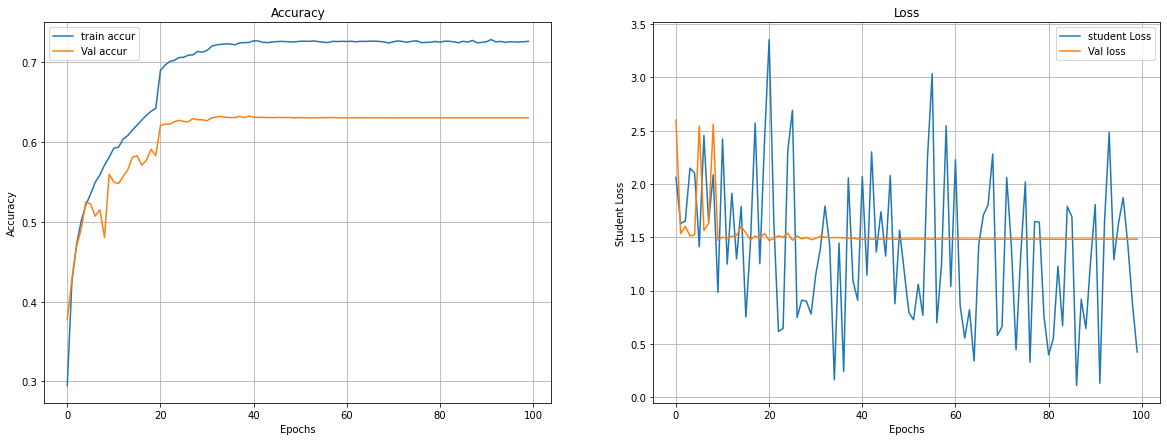

Saving model 


2022-06-13 13:11:26.018840: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Lenet5_KD_alpha0.1/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 65s 40ms/step - sparse_categorical_accuracy: 0.3068 - student_loss: 2.0816 - Dist_loss: 1.5535 - loss: 1.6591 - val_sparse_categorical_accuracy: 0.3650 - val_student_loss: 2.4193 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4203 - student_loss: 1.9458 - Dist_loss: 1.2999 - loss: 1.4291 - val_sparse_categorical_accuracy: 0.4470 - val_student_loss: 1.4326 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4705 - student_loss: 1.8635 - Dist_loss: 1.1777 - loss: 1.3149 - val_sparse_categorical_accuracy: 0.4921 - val_student_loss: 1.4514 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5066 - student_loss: 1.7894 - Dist_lo

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6981 - student_loss: 1.1372 - Dist_loss: 0.6665 - loss: 0.7607 - val_sparse_categorical_accuracy: 0.6299 - val_student_loss: 1.5495 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.6993 - student_loss: 1.1437 - Dist_loss: 0.6671 - loss: 0.7624
Epoch 32: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6993 - student_loss: 1.1436 - Dist_loss: 0.6670 - loss: 0.7624 - val_sparse_categorical_accuracy: 0.6280 - val_student_loss: 1.5525 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7008 - student_loss: 1.1380 - Dist_loss: 0.6652 - loss: 0.7597 - val_sparse_categorical_accuracy: 0.6291 - val_student_loss: 1.5482 - lr: 1.0000e-04
Epoch 34/100
1562/1562 [=

Epoch 61/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6998 - student_loss: 1.1390 - Dist_loss: 0.6645 - loss: 0.7594 - val_sparse_categorical_accuracy: 0.6291 - val_student_loss: 1.5467 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7009 - student_loss: 1.1321 - Dist_loss: 0.6629 - loss: 0.7567 - val_sparse_categorical_accuracy: 0.6291 - val_student_loss: 1.5467 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6995 - student_loss: 1.1333 - Dist_loss: 0.6640 - loss: 0.7579 - val_sparse_categorical_accuracy: 0.6291 - val_student_loss: 1.5467 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6999 - student_loss: 1.1335 - Dist_loss: 0.6640 - loss: 0.7579 - val_sparse_categorical_accuracy: 0.6291 - val_student_loss: 1.5468 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7001 - student_loss: 1.1294 - Dist_loss: 0.6629 - loss: 0.7562 - val_sparse_categorical_accuracy: 0.6292 - val_student_loss: 1.5470 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7004 - student_loss: 1.1365 - Dist_loss: 0.6644 - loss: 0.7588 - val_sparse_categorical_accuracy: 0.6292 - val_student_loss: 1.5470 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7001 - student_loss: 1.1318 - Dist_loss: 0.6639 - loss: 0.7575 - val_sparse_categorical_accuracy: 0.6292 - val_student_loss: 1.5470 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6992 - student_loss: 1.1358 - Dist_loss: 0.6649 - loss: 0.7591 - val_sparse_categorical_accuracy: 0.6292 - val_student_loss: 1.5470 - lr: 1.0000e-

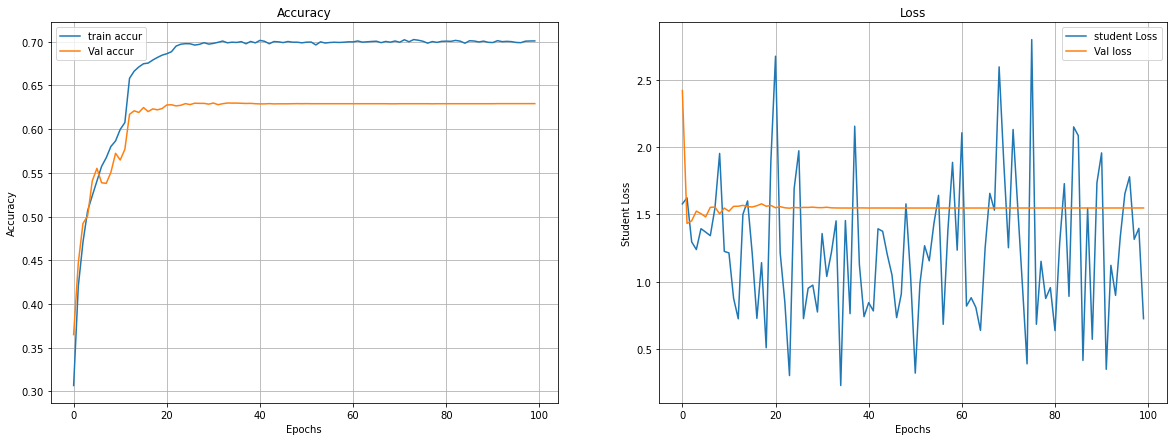

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_alpha0.2/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.3223 - student_loss: 1.9587 - Dist_loss: 1.5508 - loss: 1.6732 - val_sparse_categorical_accuracy: 0.4012 - val_student_loss: 1.5670 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4440 - student_loss: 1.7312 - Dist_loss: 1.2923 - loss: 1.4239 - val_sparse_categorical_accuracy: 0.4586 - val_student_loss: 1.5796 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4883 - student_loss: 1.6303 - Dist_loss: 1.1820 - loss: 1.3165 - val_sparse_categorical_accuracy: 0.5065 - val_student_loss: 1.6173 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5185 - student_loss: 1.

Epoch 31/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7209 - student_loss: 0.9362 - Dist_loss: 0.6642 - loss: 0.7458 - val_sparse_categorical_accuracy: 0.6323 - val_student_loss: 2.6168 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7213 - student_loss: 0.9351 - Dist_loss: 0.6629 - loss: 0.7445 - val_sparse_categorical_accuracy: 0.6311 - val_student_loss: 2.6160 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7205 - student_loss: 0.9353 - Dist_loss: 0.6631 - loss: 0.7448 - val_sparse_categorical_accuracy: 0.6325 - val_student_loss: 2.6167 - lr: 1.0000e-03
Epoch 34/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.7216 - student_loss: 0.9309 - Dist_loss: 0.6618 - loss: 0.7425
Epoch 34: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 61/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7216 - student_loss: 0.9318 - Dist_loss: 0.6617 - loss: 0.7427 - val_sparse_categorical_accuracy: 0.6320 - val_student_loss: 2.6153 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7222 - student_loss: 0.9333 - Dist_loss: 0.6620 - loss: 0.7433 - val_sparse_categorical_accuracy: 0.6320 - val_student_loss: 2.6153 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7236 - student_loss: 0.9311 - Dist_loss: 0.6598 - loss: 0.7412 - val_sparse_categorical_accuracy: 0.6320 - val_student_loss: 2.6153 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7224 - student_loss: 0.9331 - Dist_loss: 0.6610 - loss: 0.7426 - val_sparse_categorical_accuracy: 0.6320 - val_student_loss: 2.6153 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7238 - student_loss: 0.9270 - Dist_loss: 0.6595 - loss: 0.7398 - val_sparse_categorical_accuracy: 0.6317 - val_student_loss: 2.6157 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7231 - student_loss: 0.9278 - Dist_loss: 0.6610 - loss: 0.7410 - val_sparse_categorical_accuracy: 0.6317 - val_student_loss: 2.6157 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7238 - student_loss: 0.9292 - Dist_loss: 0.6606 - loss: 0.7412 - val_sparse_categorical_accuracy: 0.6317 - val_student_loss: 2.6157 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7218 - student_loss: 0.9316 - Dist_loss: 0.6614 - loss: 0.7425 - val_sparse_categorical_accuracy: 0.6317 - val_student_loss: 2.6157 - lr: 1.0000e-

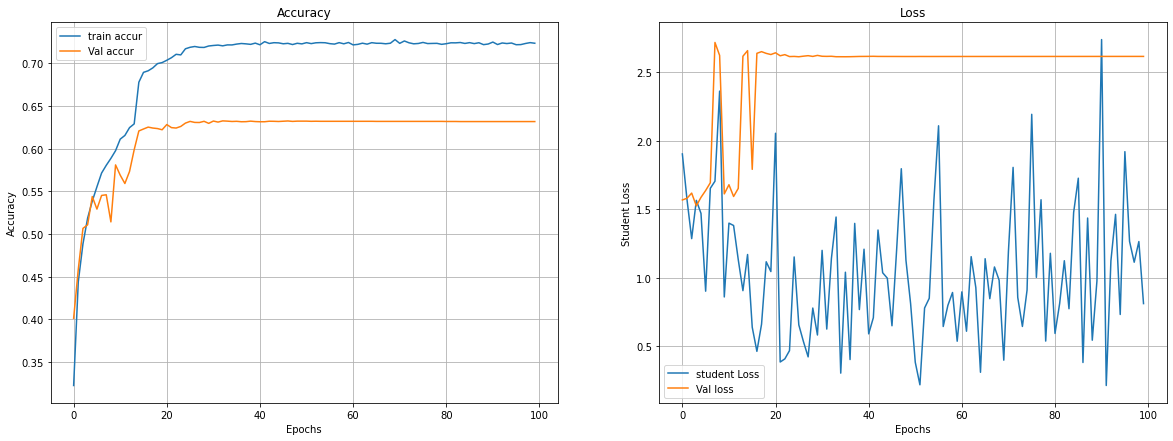

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_alpha0.3/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.3046 - student_loss: 1.9491 - Dist_loss: 1.6039 - loss: 1.7420 - val_sparse_categorical_accuracy: 0.4054 - val_student_loss: 2.5056 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4329 - student_loss: 1.6686 - Dist_loss: 1.3702 - loss: 1.4896 - val_sparse_categorical_accuracy: 0.4411 - val_student_loss: 1.5085 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4761 - student_loss: 1.5701 - Dist_loss: 1.2719 - loss: 1.3912 - val_sparse_categorical_accuracy: 0.4772 - val_student_loss: 2.6230 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5042 - student_loss: 1.

Epoch 31/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6932 - student_loss: 0.9485 - Dist_loss: 0.7637 - loss: 0.8376 - val_sparse_categorical_accuracy: 0.6131 - val_student_loss: 1.5440 - lr: 1.0000e-03
Epoch 32/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.6965 - student_loss: 0.9464 - Dist_loss: 0.7631 - loss: 0.8365
Epoch 32: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6965 - student_loss: 0.9467 - Dist_loss: 0.7633 - loss: 0.8366 - val_sparse_categorical_accuracy: 0.6106 - val_student_loss: 1.5577 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6944 - student_loss: 0.9471 - Dist_loss: 0.7623 - loss: 0.8362 - val_sparse_categorical_accuracy: 0.6122 - val_student_loss: 1.5464 - lr: 1.0000e-04
Epoch 34/100

Epoch 61/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6961 - student_loss: 0.9430 - Dist_loss: 0.7597 - loss: 0.8330 - val_sparse_categorical_accuracy: 0.6118 - val_student_loss: 1.5467 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.6996 - student_loss: 0.9332 - Dist_loss: 0.7589 - loss: 0.8286 - val_sparse_categorical_accuracy: 0.6118 - val_student_loss: 1.5467 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6967 - student_loss: 0.9388 - Dist_loss: 0.7599 - loss: 0.8315 - val_sparse_categorical_accuracy: 0.6118 - val_student_loss: 1.5466 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6961 - student_loss: 0.9426 - Dist_loss: 0.7610 - loss: 0.8337 - val_sparse_categorical_accuracy: 0.6118 - val_student_loss: 1.5466 -

1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6989 - student_loss: 0.9390 - Dist_loss: 0.7597 - loss: 0.8314 - val_sparse_categorical_accuracy: 0.6118 - val_student_loss: 1.5466 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6981 - student_loss: 0.9391 - Dist_loss: 0.7607 - loss: 0.8320 - val_sparse_categorical_accuracy: 0.6118 - val_student_loss: 1.5466 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6958 - student_loss: 0.9432 - Dist_loss: 0.7607 - loss: 0.8337 - val_sparse_categorical_accuracy: 0.6118 - val_student_loss: 1.5466 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6990 - student_loss: 0.9371 - Dist_loss: 0.7588 - loss: 0.8301 - val_sparse_categorical_accuracy: 0.6118 - val_student_loss: 1.5466 - lr: 1.0000e-

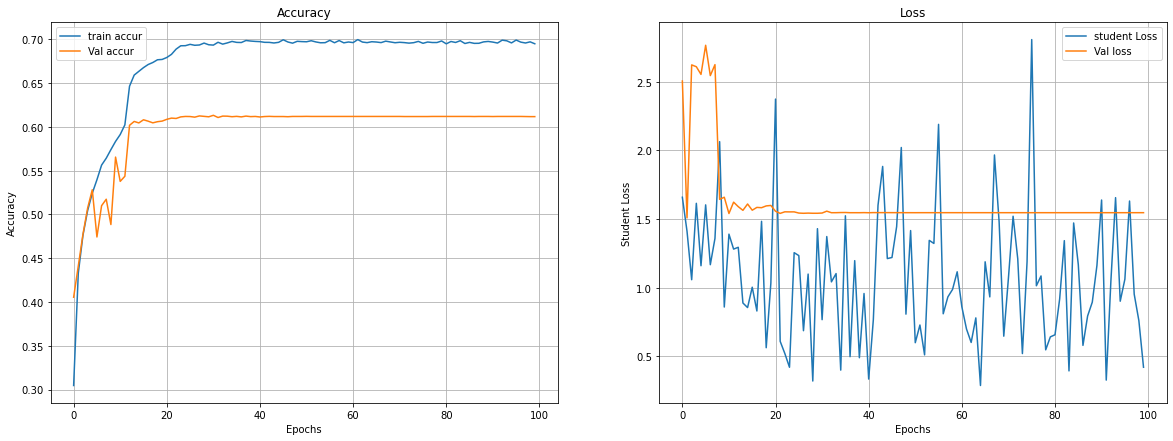

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_alpha0.4/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.3117 - student_loss: 1.9162 - Dist_loss: 1.6097 - loss: 1.7630 - val_sparse_categorical_accuracy: 0.3686 - val_student_loss: 1.5823 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4416 - student_loss: 1.6015 - Dist_loss: 1.3874 - loss: 1.4945 - val_sparse_categorical_accuracy: 0.4574 - val_student_loss: 2.5422 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.4799 - student_loss: 1.5064 - Dist_loss: 1.2979 - loss: 1.4021 - val_sparse_categorical_accuracy: 0.4817 - val_student_loss: 2.6222 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.5026 - student_loss: 1.

Epoch 31/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.6953 - student_loss: 0.9078 - Dist_loss: 0.8066 - loss: 0.8572
Epoch 31: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.6953 - student_loss: 0.9079 - Dist_loss: 0.8066 - loss: 0.8573 - val_sparse_categorical_accuracy: 0.6166 - val_student_loss: 2.6944 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6966 - student_loss: 0.9057 - Dist_loss: 0.8057 - loss: 0.8557 - val_sparse_categorical_accuracy: 0.6161 - val_student_loss: 2.6950 - lr: 1.0000e-04
Epoch 33/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6946 - student_loss: 0.9043 - Dist_loss: 0.8061 - loss: 0.8552 - val_sparse_categorical_accuracy: 0.6163 - val_student_loss: 2.6964 - lr: 1.0000e-04
Epoch 34/100

Epoch 61/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.6976 - student_loss: 0.9063 - Dist_loss: 0.8050 - loss: 0.8557 - val_sparse_categorical_accuracy: 0.6164 - val_student_loss: 2.6961 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.6963 - student_loss: 0.9028 - Dist_loss: 0.8043 - loss: 0.8535 - val_sparse_categorical_accuracy: 0.6164 - val_student_loss: 2.6961 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.6979 - student_loss: 0.9038 - Dist_loss: 0.8037 - loss: 0.8538 - val_sparse_categorical_accuracy: 0.6164 - val_student_loss: 2.6961 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6961 - student_loss: 0.9031 - Dist_loss: 0.8035 - loss: 0.8533 - val_sparse_categorical_accuracy: 0.6164 - val_student_loss: 2.6961 -

1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.6978 - student_loss: 0.9056 - Dist_loss: 0.8050 - loss: 0.8553 - val_sparse_categorical_accuracy: 0.6165 - val_student_loss: 2.6961 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.6976 - student_loss: 0.9003 - Dist_loss: 0.8039 - loss: 0.8521 - val_sparse_categorical_accuracy: 0.6165 - val_student_loss: 2.6962 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.6965 - student_loss: 0.9029 - Dist_loss: 0.8043 - loss: 0.8536 - val_sparse_categorical_accuracy: 0.6165 - val_student_loss: 2.6962 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.6960 - student_loss: 0.9049 - Dist_loss: 0.8053 - loss: 0.8551 - val_sparse_categorical_accuracy: 0.6166 - val_student_loss: 2.6962 - lr: 1.0000e-

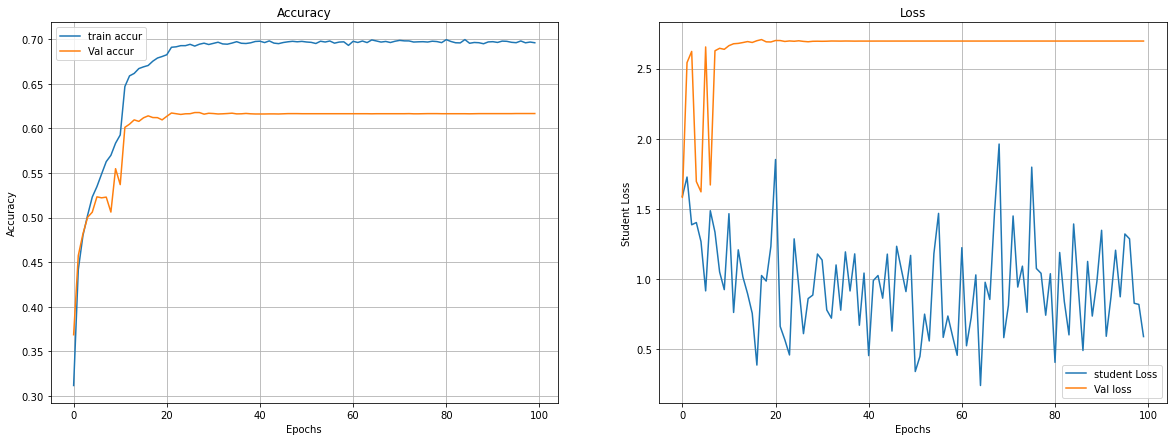

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_alpha0.5/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.3330 - student_loss: 1.8579 - Dist_loss: 1.5951 - loss: 1.7528 - val_sparse_categorical_accuracy: 0.4071 - val_student_loss: 1.3751 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.4465 - student_loss: 1.5716 - Dist_loss: 1.4080 - loss: 1.5062 - val_sparse_categorical_accuracy: 0.4678 - val_student_loss: 1.4667 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.4848 - student_loss: 1.4670 - Dist_loss: 1.3270 - loss: 1.4110 - val_sparse_categorical_accuracy: 0.4778 - val_student_loss: 1.5906 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.5118 - student_loss: 1.

Epoch 31/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.7119 - student_loss: 0.8355 - Dist_loss: 0.8078 - loss: 0.8244
Epoch 31: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7119 - student_loss: 0.8358 - Dist_loss: 0.8079 - loss: 0.8246 - val_sparse_categorical_accuracy: 0.6342 - val_student_loss: 1.6042 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7128 - student_loss: 0.8342 - Dist_loss: 0.8076 - loss: 0.8235 - val_sparse_categorical_accuracy: 0.6351 - val_student_loss: 1.6041 - lr: 1.0000e-04
Epoch 33/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7117 - student_loss: 0.8328 - Dist_loss: 0.8078 - loss: 0.8228 - val_sparse_categorical_accuracy: 0.6352 - val_student_loss: 1.6040 - lr: 1.0000e-04
Epoch 34/100

Epoch 61/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7155 - student_loss: 0.8322 - Dist_loss: 0.8056 - loss: 0.8216 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.6022 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7122 - student_loss: 0.8340 - Dist_loss: 0.8064 - loss: 0.8230 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.6022 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7120 - student_loss: 0.8370 - Dist_loss: 0.8070 - loss: 0.8250 - val_sparse_categorical_accuracy: 0.6357 - val_student_loss: 1.6022 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7124 - student_loss: 0.8357 - Dist_loss: 0.8069 - loss: 0.8242 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.6022 -

1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7124 - student_loss: 0.8380 - Dist_loss: 0.8075 - loss: 0.8258 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.6022 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7142 - student_loss: 0.8338 - Dist_loss: 0.8065 - loss: 0.8229 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.6022 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7122 - student_loss: 0.8349 - Dist_loss: 0.8066 - loss: 0.8236 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.6022 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7120 - student_loss: 0.8393 - Dist_loss: 0.8068 - loss: 0.8263 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.6022 - lr: 1.0000e-

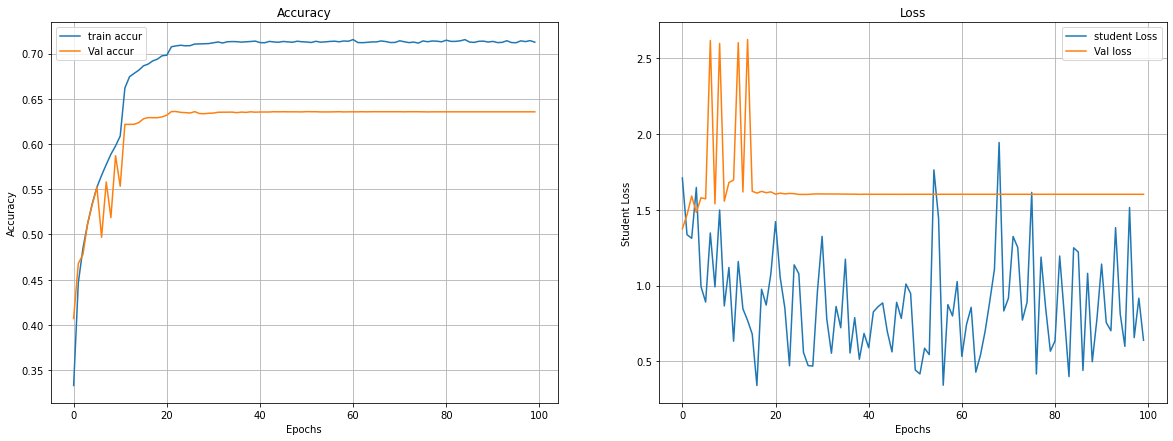

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_alpha0.6/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.3285 - student_loss: 1.8531 - Dist_loss: 1.6057 - loss: 1.7788 - val_sparse_categorical_accuracy: 0.3945 - val_student_loss: 2.3800 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.4521 - student_loss: 1.5286 - Dist_loss: 1.4230 - loss: 1.4969 - val_sparse_categorical_accuracy: 0.4630 - val_student_loss: 1.4946 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.4944 - student_loss: 1.4183 - Dist_loss: 1.3424 - loss: 1.3955 - val_sparse_categorical_accuracy: 0.4909 - val_student_loss: 2.6333 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.5205 - student_loss: 1.

Epoch 31/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7407 - student_loss: 0.7383 - Dist_loss: 0.7844 - loss: 0.7521 - val_sparse_categorical_accuracy: 0.6430 - val_student_loss: 1.6043 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7403 - student_loss: 0.7401 - Dist_loss: 0.7847 - loss: 0.7535 - val_sparse_categorical_accuracy: 0.6416 - val_student_loss: 1.6065 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7389 - student_loss: 0.7421 - Dist_loss: 0.7832 - loss: 0.7544 - val_sparse_categorical_accuracy: 0.6422 - val_student_loss: 1.6032 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7379 - student_loss: 0.7391 - Dist_loss: 0.7823 - loss: 0.7520 - val_sparse_categorical_accuracy: 0.6413 - val_student_loss: 1.6006 -

Epoch 61/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7405 - student_loss: 0.7346 - Dist_loss: 0.7802 - loss: 0.7483 - val_sparse_categorical_accuracy: 0.6422 - val_student_loss: 1.5996 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7412 - student_loss: 0.7352 - Dist_loss: 0.7794 - loss: 0.7485 - val_sparse_categorical_accuracy: 0.6422 - val_student_loss: 1.5996 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7403 - student_loss: 0.7354 - Dist_loss: 0.7801 - loss: 0.7488 - val_sparse_categorical_accuracy: 0.6422 - val_student_loss: 1.5996 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7418 - student_loss: 0.7322 - Dist_loss: 0.7793 - loss: 0.7463 - val_sparse_categorical_accuracy: 0.6422 - val_student_loss: 1.5996 -

1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7423 - student_loss: 0.7361 - Dist_loss: 0.7799 - loss: 0.7492 - val_sparse_categorical_accuracy: 0.6422 - val_student_loss: 1.5999 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7417 - student_loss: 0.7342 - Dist_loss: 0.7792 - loss: 0.7477 - val_sparse_categorical_accuracy: 0.6422 - val_student_loss: 1.5999 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7416 - student_loss: 0.7364 - Dist_loss: 0.7802 - loss: 0.7495 - val_sparse_categorical_accuracy: 0.6422 - val_student_loss: 1.5999 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7413 - student_loss: 0.7342 - Dist_loss: 0.7804 - loss: 0.7481 - val_sparse_categorical_accuracy: 0.6422 - val_student_loss: 1.5999 - lr: 1.0000e-

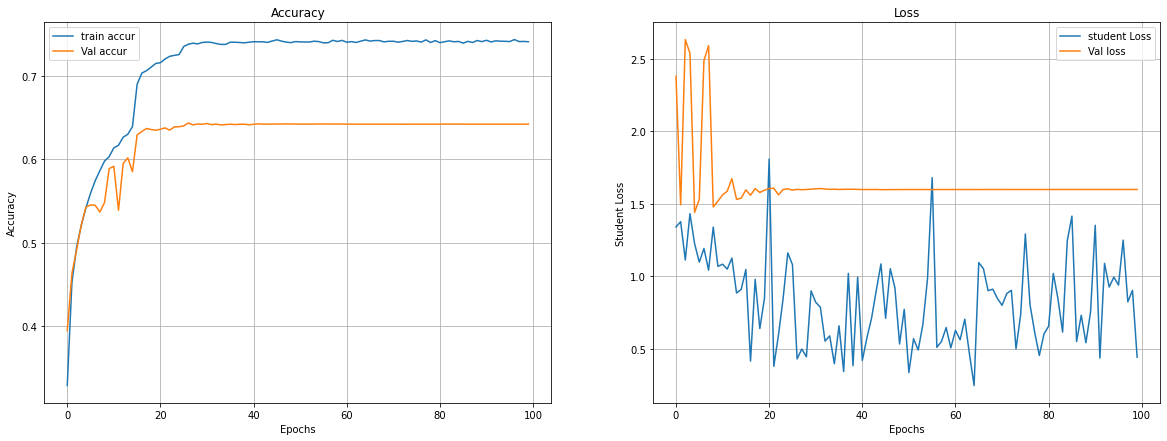

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_alpha0.7/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.3264 - student_loss: 1.8626 - Dist_loss: 1.6193 - loss: 1.8139 - val_sparse_categorical_accuracy: 0.4238 - val_student_loss: 2.2955 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.4478 - student_loss: 1.5522 - Dist_loss: 1.4586 - loss: 1.5335 - val_sparse_categorical_accuracy: 0.4331 - val_student_loss: 1.3979 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.4795 - student_loss: 1.4612 - Dist_loss: 1.4001 - loss: 1.4490 - val_sparse_categorical_accuracy: 0.4697 - val_student_loss: 2.4466 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.5026 - student_loss: 1.

Epoch 31/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7429 - student_loss: 0.7187 - Dist_loss: 0.8308 - loss: 0.7411 - val_sparse_categorical_accuracy: 0.6389 - val_student_loss: 1.6385 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7440 - student_loss: 0.7128 - Dist_loss: 0.8243 - loss: 0.7351 - val_sparse_categorical_accuracy: 0.6412 - val_student_loss: 1.6330 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7462 - student_loss: 0.7145 - Dist_loss: 0.8235 - loss: 0.7363 - val_sparse_categorical_accuracy: 0.6409 - val_student_loss: 1.6335 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7447 - student_loss: 0.7118 - Dist_loss: 0.8214 - loss: 0.7337 - val_sparse_categorical_accuracy: 0.6404 - val_student_loss: 1.6334 -

Epoch 61/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7475 - student_loss: 0.7062 - Dist_loss: 0.8116 - loss: 0.7273 - val_sparse_categorical_accuracy: 0.6409 - val_student_loss: 1.6408 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7497 - student_loss: 0.7043 - Dist_loss: 0.8121 - loss: 0.7259 - val_sparse_categorical_accuracy: 0.6409 - val_student_loss: 1.6408 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7505 - student_loss: 0.7053 - Dist_loss: 0.8115 - loss: 0.7266 - val_sparse_categorical_accuracy: 0.6409 - val_student_loss: 1.6408 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7490 - student_loss: 0.7046 - Dist_loss: 0.8107 - loss: 0.7258 - val_sparse_categorical_accuracy: 0.6409 - val_student_loss: 1.6408 -

1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7471 - student_loss: 0.7049 - Dist_loss: 0.8120 - loss: 0.7263 - val_sparse_categorical_accuracy: 0.6407 - val_student_loss: 1.6408 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7489 - student_loss: 0.7045 - Dist_loss: 0.8120 - loss: 0.7260 - val_sparse_categorical_accuracy: 0.6407 - val_student_loss: 1.6408 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7504 - student_loss: 0.7006 - Dist_loss: 0.8116 - loss: 0.7228 - val_sparse_categorical_accuracy: 0.6408 - val_student_loss: 1.6408 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7474 - student_loss: 0.7033 - Dist_loss: 0.8107 - loss: 0.7248 - val_sparse_categorical_accuracy: 0.6407 - val_student_loss: 1.6408 - lr: 1.0000e-

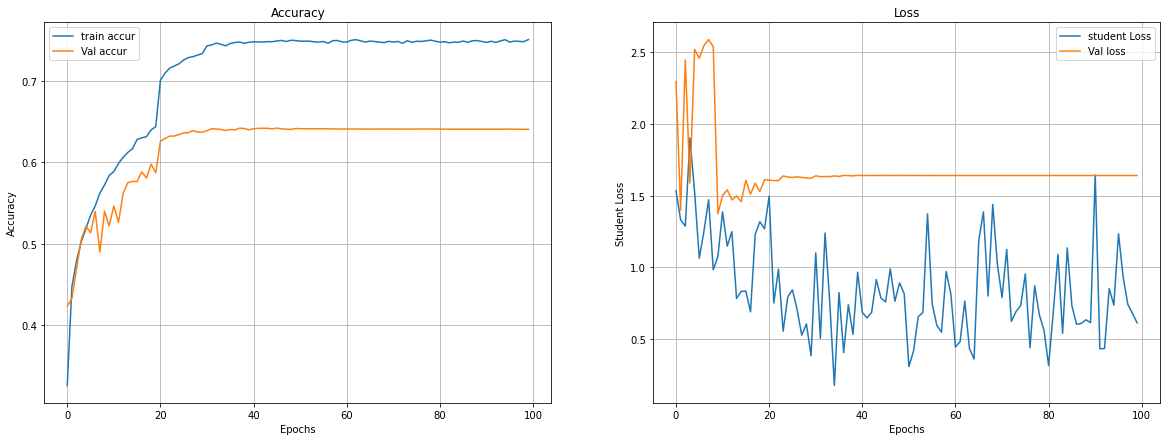

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_alpha0.8/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 64s 40ms/step - sparse_categorical_accuracy: 0.2954 - student_loss: 1.9171 - Dist_loss: 1.6490 - loss: 1.8903 - val_sparse_categorical_accuracy: 0.4047 - val_student_loss: 2.3690 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.4295 - student_loss: 1.5731 - Dist_loss: 1.4884 - loss: 1.5646 - val_sparse_categorical_accuracy: 0.3597 - val_student_loss: 1.6318 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.4797 - student_loss: 1.4517 - Dist_loss: 1.4240 - loss: 1.4489 - val_sparse_categorical_accuracy: 0.4945 - val_student_loss: 2.4130 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.5070 - student_loss: 1.

Epoch 31/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7347 - student_loss: 0.7518 - Dist_loss: 0.9384 - loss: 0.7704 - val_sparse_categorical_accuracy: 0.6362 - val_student_loss: 1.5167 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7330 - student_loss: 0.7535 - Dist_loss: 0.9381 - loss: 0.7720 - val_sparse_categorical_accuracy: 0.6353 - val_student_loss: 1.5118 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7334 - student_loss: 0.7516 - Dist_loss: 0.9379 - loss: 0.7702 - val_sparse_categorical_accuracy: 0.6352 - val_student_loss: 1.5128 - lr: 1.0000e-03
Epoch 34/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.7368 - student_loss: 0.7479 - Dist_loss: 0.9362 - loss: 0.7667
Epoch 34: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 61/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7355 - student_loss: 0.7473 - Dist_loss: 0.9337 - loss: 0.7659 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.5138 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7363 - student_loss: 0.7444 - Dist_loss: 0.9333 - loss: 0.7633 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.5138 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7357 - student_loss: 0.7452 - Dist_loss: 0.9340 - loss: 0.7641 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.5138 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 61s 39ms/step - sparse_categorical_accuracy: 0.7359 - student_loss: 0.7475 - Dist_loss: 0.9333 - loss: 0.7661 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.5138 -

1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7365 - student_loss: 0.7489 - Dist_loss: 0.9343 - loss: 0.7674 - val_sparse_categorical_accuracy: 0.6356 - val_student_loss: 1.5140 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7386 - student_loss: 0.7416 - Dist_loss: 0.9331 - loss: 0.7608 - val_sparse_categorical_accuracy: 0.6357 - val_student_loss: 1.5140 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 62s 39ms/step - sparse_categorical_accuracy: 0.7367 - student_loss: 0.7449 - Dist_loss: 0.9339 - loss: 0.7638 - val_sparse_categorical_accuracy: 0.6357 - val_student_loss: 1.5140 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 62s 40ms/step - sparse_categorical_accuracy: 0.7356 - student_loss: 0.7488 - Dist_loss: 0.9345 - loss: 0.7674 - val_sparse_categorical_accuracy: 0.6357 - val_student_loss: 1.5140 - lr: 1.0000e-

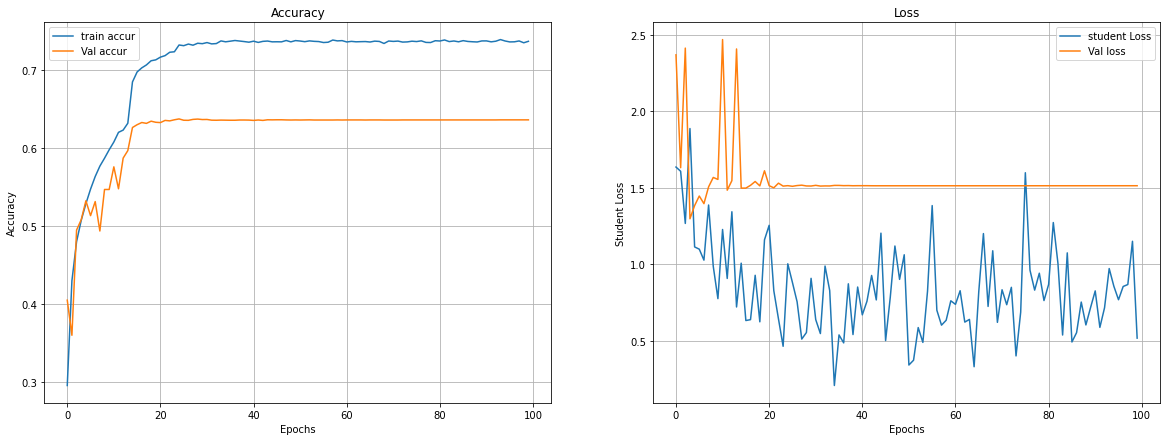

Saving model 
INFO:tensorflow:Assets written to: Lenet5_KD_alpha0.9/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [64]:
for a in A:
    # Configuration du tensorboard
    NAME = f"Lenet5_kd_alpha_{a}_temp_{5}"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                                 histogram_freq = 1)
    
    student_test = tf.keras.models.clone_model(student)

    dist = Distiller(teacher, student_test)

    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = a,
        temperature = 5)

    # Train and evaluate on data.
    hist = dist.fit(x_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Lenet5_KD_alpha{a}.png")


    print("Saving model ")
    student_test.save(f"Lenet5_KD_alpha{a}")
    print("Saving Done !")

    print("Saving Weights ")
    student_test.save_weights(f"w_Lenet5_alpha_{a}.h5")
    print("Saving Done !")
    print("")

    print("End !")